# Importing packages and getting data

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sc
import scipy.spatial.distance as sp
import matplotlib.pyplot as plt

train_data = pd.read_csv("propublicaTrain.csv")
test_data = pd.read_csv("propublicaTest.csv")
attr = train_data.columns.drop("two_year_recid")

# Helper functions

In [3]:
def gaussian(data):
    mu = data.mean(axis=0)   
    var = (data-mu).T @ (data-mu) / data.shape[0]
    return mu, var

def bayes_prob(row, train, attr):
    p = 1
    for i in range(len(attr)):
        if row[i+2] in train.index:
            p = p * train.loc[row[i+2]][attr[i]]
        else:
            return 0
    return p

# Maximum Likelihood Estimator

In [4]:
def MLE(train_data):
    
    # get data
    train_data_m0 = train_data[train_data.two_year_recid==0].fillna(0)
    train_data_m1 = train_data[train_data.two_year_recid==1].fillna(0)
    test_data_m = test_data.copy()
    test_data_m["y"] = -1

    # drop linearly dependent columns
    attr_m = attr[:-1]
    
    # generate Gaussian for the two classes
    mu_0, var_0 = gaussian(train_data_m0[attr_m])
    mu_1, var_1 = gaussian(train_data_m1[attr_m])
    
    model_0 = sc.multivariate_normal(mean=mu_0, cov=var_0)
    model_1 = sc.multivariate_normal(mean=mu_1, cov=var_1)

    # testing
    for i in range(len(test_data_m.index)):
        p_0 = model_0.pdf(test_data_m[attr_m].iloc[i])
        p_1 = model_1.pdf(test_data_m[attr_m].iloc[i])

        if p_0 > p_1:
            test_data_m["y"].iloc[i] = 0
        else:
            test_data_m["y"].iloc[i] = 1
            
    return len(test_data_m[test_data_m["two_year_recid"] == test_data_m["y"]].index)/len(test_data_m.index)

In [4]:
MLE(train_data)

0.6415

# K Nearest Neighbors

In [56]:
def KNN(k, p, train_data):
    train_data_knn = train_data.copy()
    test_data_knn = test_data.copy()
    test_data_knn["y"] = -1

    for i in range(len(test_data_knn.index)):
        distance = sp.cdist(train_data_knn[attr], test_data_knn[attr][i:i+1], 'minkowski', p)
        neighbors = np.apply_along_axis(np.argpartition, 0, distance, k)[:k] 
        test_data_knn.iloc[i]["y"] = train_data_knn.iloc[list(neighbors[:, 0]), :]["two_year_recid"].mode()[0]

    return len(test_data_knn[test_data_knn["two_year_recid"] == test_data_knn["y"]].index)/len(test_data_knn.index)
    

In [274]:
list_k = [1,10,50,200,1000]
for k in list_k:
    print("k={},  {}".format(k, KNN(k, 2, train_data)))
'''
performance before
0.605
0.6485
0.684
0.6905
0.6785
'''

k=1,  0.623
k=10,  0.6495
k=50,  0.689
k=200,  0.6895
k=1000,  0.6795


In [ ]:
list_p = [1,2,5,200,1000]
for k in list_k:
    print("k={},  {}".format(k, KNN(1, 2, train_data)))

In [269]:
KNN(5, 2, train_data)

0.6255

In [289]:
KNN(10, 2, train_data)

0.6495

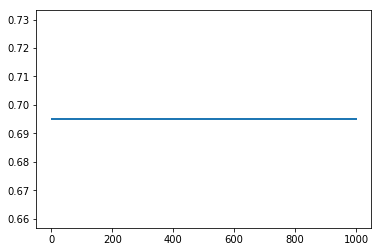

In [57]:
# Plot performance against p
x = [1,2,5,200,1000]
y = []
for k in x:
    y.append(KNN(90, p, train_data))
    
plt.plot(x, y, linewidth=2.0)

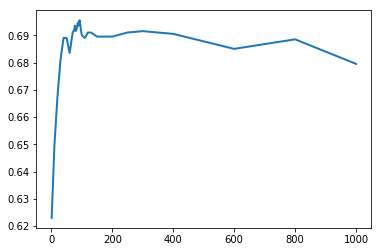

In [291]:
# Plot performance against k
x = [1,10,20,30,40,50,60,70,75,77,78,79,80,81,82,85,87,88,89,90,91,92,93,94,95,97,100,110,120,130,150,200,250,300,400,600,800,1000]
y = []
for k in x:
    y.append(KNN(k, 2, train_data))
    
plt.plot(x, y, linewidth=2.0)

In [292]:
for i in range(len(x)):
    print(x[i], y[i])

1 0.623
10 0.6495
20 0.6675
30 0.681
40 0.689
50 0.689
60 0.6835
70 0.691
75 0.692
77 0.6935
78 0.6925
79 0.692
80 0.6915
81 0.692
82 0.692
85 0.6935
87 0.6945
88 0.6935
89 0.6935
90 0.695
91 0.694
92 0.695
93 0.6955
94 0.694
95 0.694
97 0.692
100 0.69
110 0.689
120 0.691
130 0.691
150 0.6895
200 0.6895
250 0.691
300 0.6915
400 0.6905
600 0.685
800 0.6885
1000 0.6795


# Bayes Classifier

In [320]:
def NB(train_data):
    #split data 
    train_data_b0 = train_data[train_data.two_year_recid==0].apply(pd.Series.value_counts).fillna(0)
    train_data_b1 = train_data[train_data.two_year_recid==1].apply(pd.Series.value_counts).fillna(0)

    #get counts and adjust for proportion
    counts = train_data.two_year_recid.value_counts()
    train_data_b0 = train_data_b0/counts[0]
    train_data_b1 = train_data_b1/counts[1]
    counts = counts/counts.sum()

    #get test data
    test_data_bayes = test_data.copy()
    test_data_bayes["y"] = -1

    #classification
    for row in test_data.itertuples():
        p_0 = bayes_prob(row, train_data_b0, attr) * counts[0]
        p_1 = bayes_prob(row, train_data_b1, attr) * counts[1]

        #give label
        if p_0 > p_1:
            test_data_bayes["y"].loc[row[0]] = 0
        else:
            test_data_bayes["y"].loc[row[0]] = 1
    
    return len(test_data_bayes[test_data_bayes["two_year_recid"] == test_data_bayes["y"]].index)/len(test_data_bayes.index)


In [321]:
NB(train_data)

0.68

# Performance Graphs

In [293]:
train_data.shape[0]/100

41.67

In [322]:
x = []
y_mle = []
y_knn = []
y_bay = []
N = 100
step = train_data.shape[0]/N

for k in range(10,N):
    print(k)
    i = int(k*step)
    train_data_curr = train_data[:i]
    x.append(i)
    y_mle.append(MLE(train_data_curr))
    y_knn.append(KNN(90,2,train_data_curr))
    y_bay.append(NB(train_data_curr))

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [316]:
MLE(train_data_curr)

0.6265

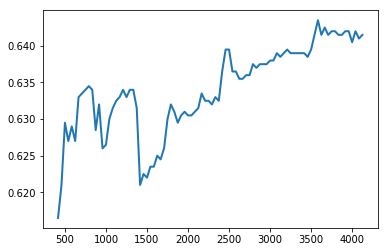

In [325]:
plt.plot(x, y_mle, linewidth=2.0)

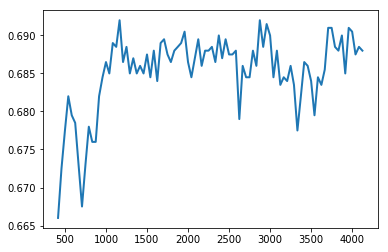

In [326]:
plt.plot(x, y_knn, linewidth=2.0)

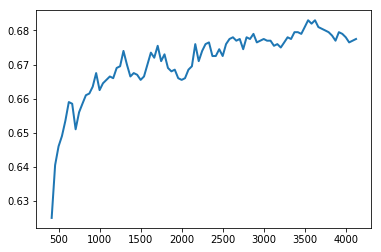

In [327]:
plt.plot(x, y_bay, linewidth=2.0)

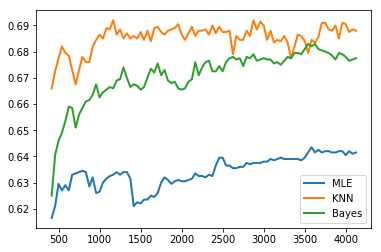

In [332]:
plt.plot(x, y_mle, linewidth=2.0)
plt.plot(x, y_knn, linewidth=2.0)
plt.plot(x, y_bay, linewidth=2.0)
plt.legend(['MLE', 'KNN', 'Bayes'], loc='lower right')

# Fairness Condition

In [5]:
def print_fairness(dataset):
    curr_data = dataset

    ## Demographic Parity
    print("Demographic Parity")
    N0 = len(curr_data[curr_data["race"] == 0].index)
    N1 = len(curr_data[curr_data["race"] == 1].index)
    print("P_0(0): ", len(curr_data[curr_data["race"] == 0][curr_data["y"] == 0].index)/N0)
    print("P_1(0): ", len(curr_data[curr_data["race"] == 1][curr_data["y"] == 0].index)/N1)
    print("P_0(1): ", len(curr_data[curr_data["race"] == 0][curr_data["y"] == 1].index)/N0)
    print("P_1(1): ", len(curr_data[curr_data["race"] == 1][curr_data["y"] == 1].index)/N1)

    ## Equalized Odds
    print("\nEqualized Odds")
    prior_00 = curr_data[curr_data["race"] == 0][curr_data["two_year_recid"]==0]
    prior_10 = curr_data[curr_data["race"] == 1][curr_data["two_year_recid"]==0]
    prior_01 = curr_data[curr_data["race"] == 0][curr_data["two_year_recid"]==1]
    prior_11 = curr_data[curr_data["race"] == 1][curr_data["two_year_recid"]==1]
    # True Negative
    print("P_0(Y_hat = 0 | Y = 0): ", len(prior_00[curr_data["y"] == 0].index)/len(prior_00.index))
    print("P_1(Y_hat = 0 | Y = 0): ", len(prior_10[curr_data["y"] == 0].index)/len(prior_10.index))
    # True Positive
    print("P_0(Y_hat = 1 | Y = 1): ", len(prior_01[curr_data["y"] == 1].index)/len(prior_01.index))
    print("P_1(Y_hat = 1 | Y = 1): ", len(prior_11[curr_data["y"] == 1].index)/len(prior_11.index))

    ## Predictive Parity
    print("\nPredictive Parity")
    prior_00h = curr_data[curr_data["race"] == 0][curr_data["y"]==0]
    prior_10h = curr_data[curr_data["race"] == 1][curr_data["y"]==0]
    prior_01h = curr_data[curr_data["race"] == 0][curr_data["y"]==1]
    prior_11h = curr_data[curr_data["race"] == 1][curr_data["y"]==1]
    # Negative Predicative
    print("P_0(Y = 0 | Y_hat = 0): ", len(prior_00h[curr_data["two_year_recid"] == 0].index)/len(prior_00h.index))
    print("P_1(Y = 0 | Y_hat = 0): ", len(prior_10h[curr_data["two_year_recid"] == 0].index)/len(prior_10h.index))
    # Positive Predicative
    print("P_0(Y = 1 | Y_hat = 1): ", len(prior_01h[curr_data["two_year_recid"] == 1].index)/len(prior_01h.index))
    print("P_1(Y = 1 | Y_hat = 1): ", len(prior_11h[curr_data["two_year_recid"] == 1].index)/len(prior_11h.index))
    
    return

In [6]:
### MLE

# get data
train_data_m0 = train_data[train_data.two_year_recid==0].fillna(0)
train_data_m1 = train_data[train_data.two_year_recid==1].fillna(0)
test_data_m = test_data.copy()
test_data_m["y"] = -1

# drop linearly dependent columns
attr_m = attr[:-1]

# generate Gaussian for the two classes
mu_0, var_0 = gaussian(train_data_m0[attr_m])
mu_1, var_1 = gaussian(train_data_m1[attr_m])

model_0 = sc.multivariate_normal(mean=mu_0, cov=var_0)
model_1 = sc.multivariate_normal(mean=mu_1, cov=var_1)

# testing
for i in range(len(test_data_m.index)):
    p_0 = model_0.pdf(test_data_m[attr_m].iloc[i])
    p_1 = model_1.pdf(test_data_m[attr_m].iloc[i])

    if p_0 > p_1:
        test_data_m["y"].iloc[i] = 0
    else:
        test_data_m["y"].iloc[i] = 1

print("MLE ", len(test_data_m[test_data_m["two_year_recid"] == test_data_m["y"]].index)/len(test_data_m.index))
print_fairness(test_data_m)

MLE  0.6415
Demographic Parity
P_0(0):  0.7896706586826348
P_1(0):  0.8960843373493976
P_0(1):  0.21032934131736528
P_1(1):  0.10391566265060241

Equalized Odds
P_0(Y_hat = 0 | Y = 0):  0.9113372093023255
P_1(Y_hat = 0 | Y = 0):  0.9553349875930521
P_0(Y_hat = 1 | Y = 1):  0.3395061728395062
P_1(Y_hat = 1 | Y = 1):  0.19540229885057472

Predictive Parity
P_0(Y = 0 | Y_hat = 0):  0.5943127962085308
P_1(Y = 0 | Y_hat = 0):  0.6470588235294118
P_0(Y = 1 | Y_hat = 1):  0.7829181494661922
P_1(Y = 1 | Y_hat = 1):  0.7391304347826086


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindex

In [7]:
### KNN

k = 90
p = 2

train_data_knn = train_data.copy()
test_data_knn = test_data.copy()
test_data_knn["y"] = -1

for i in range(len(test_data_knn.index)):
    distance = sp.cdist(train_data_knn[attr], test_data_knn[attr][i:i+1], 'minkowski', p)
    neighbors = np.apply_along_axis(np.argpartition, 0, distance, k)[:k] 
    test_data_knn.iloc[i]["y"] = train_data_knn.iloc[list(neighbors[:, 0]), :]["two_year_recid"].mode()[0]

print(len(test_data_knn[test_data_knn["two_year_recid"] == test_data_knn["y"]].index)/len(test_data_knn.index))
print_fairness(test_data_knn)

0.695
Demographic Parity
P_0(0):  0.5239520958083832
P_1(0):  0.7364457831325302
P_0(1):  0.47604790419161674
P_1(1):  0.2635542168674699

Equalized Odds
P_0(Y_hat = 0 | Y = 0):  0.7122093023255814
P_1(Y_hat = 0 | Y = 0):  0.8560794044665012
P_0(Y_hat = 1 | Y = 1):  0.6759259259259259
P_1(Y_hat = 1 | Y = 1):  0.4482758620689655

Predictive Parity
P_0(Y = 0 | Y_hat = 0):  0.7
P_1(Y = 0 | Y_hat = 0):  0.7055214723926381
P_0(Y = 1 | Y_hat = 1):  0.6886792452830188
P_1(Y = 1 | Y_hat = 1):  0.6685714285714286


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindex

In [8]:
## BAY

#split data 
train_data_b0 = train_data[train_data.two_year_recid==0].apply(pd.Series.value_counts).fillna(0)
train_data_b1 = train_data[train_data.two_year_recid==1].apply(pd.Series.value_counts).fillna(0)

#get counts and adjust for proportion
counts = train_data.two_year_recid.value_counts()
train_data_b0 = train_data_b0/counts[0]
train_data_b1 = train_data_b1/counts[1]
counts = counts/counts.sum()

#get test data
test_data_bayes = test_data.copy()
test_data_bayes["y"] = -1

#classification
for row in test_data.itertuples():
    p_0 = bayes_prob(row, train_data_b0, attr) * counts[0]
    p_1 = bayes_prob(row, train_data_b1, attr) * counts[1]

    #give label
    if p_0 > p_1:
        test_data_bayes["y"].loc[row[0]] = 0
    else:
        test_data_bayes["y"].loc[row[0]] = 1

print(len(test_data_bayes[test_data_bayes["two_year_recid"] == test_data_bayes["y"]].index)/len(test_data_bayes.index))
print_fairness(test_data_bayes)

0.68
Demographic Parity
P_0(0):  0.5291916167664671
P_1(0):  0.7801204819277109
P_0(1):  0.4708083832335329
P_1(1):  0.21987951807228914

Equalized Odds
P_0(Y_hat = 0 | Y = 0):  0.7063953488372093
P_1(Y_hat = 0 | Y = 0):  0.8734491315136477
P_0(Y_hat = 1 | Y = 1):  0.6589506172839507
P_1(Y_hat = 1 | Y = 1):  0.36398467432950193

Predictive Parity
P_0(Y = 0 | Y_hat = 0):  0.6874115983026874
P_1(Y = 0 | Y_hat = 0):  0.6795366795366795
P_0(Y = 1 | Y_hat = 1):  0.6788553259141494
P_1(Y = 1 | Y_hat = 1):  0.6506849315068494


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindex

In [49]:
# Define Plotting Variables 

DP = np.array([[0.7896706586826348, 0.8960843373493976],   # MLE
               [0.5239520958083832, 0.7364457831325302],   # KNN
               [0.5291916167664671, 0.7801204819277109]])  # BAY
EO_neg = np.array([[0.9113372093023255, 0.9553349875930521],
                   [0.7122093023255814, 0.8560794044665012],
                   [0.7063953488372093, 0.8734491315136477]])
EO_pos = np.array([[0.3395061728395062, 0.19540229885057472],
                   [0.6759259259259259, 0.4482758620689655],
                   [0.6589506172839507, 0.36398467432950193]])
PP_neg = np.array([[0.5943127962085308, 0.6470588235294118],
                   [0.7,  0.7055214723926381],
                   [0.6874115983026874, 0.6795366795366795]] )
PP_pos = np.array([[0.3395061728395062, 0.19540229885057472],
                   [0.6886792452830188, 0.6685714285714286],
                   [0.6788553259141494, 0.6506849315068494]])

In [40]:
def plot_fairness(data, name):
    N = 3
    ind = np.arange(N)  # the x locations for the groups
    width = 0.27       # the width of the bars

    fig = plt.figure()
    ax = fig.add_subplot(111)

    yvals = data[:,0]
    rects1 = ax.bar(ind, yvals, width, color='blue')
    zvals = data[:,1]
    rects2 = ax.bar(ind+width, zvals, width, color='orange')

    ax.set_ylabel('Probability')
    ax.set_xticks(ind+width)
    ax.set_xticklabels( ('MLE', 'KNN', 'Bayes') )
    ax.legend( (rects1[0], rects2[0]), ('P0', 'P1'), loc='lower left')

    def autolabel(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., 1.0*h, '%.3f'%h,
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    plt.title(name)
    plt.show()
    
    return

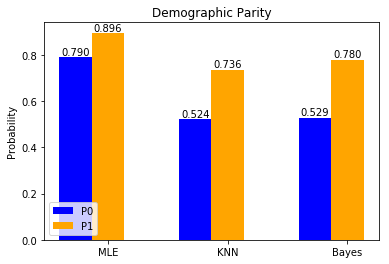

In [42]:
plot_fairness(DP, "Demographic Parity")

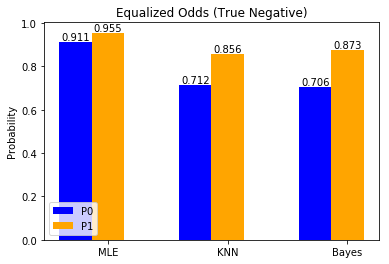

In [51]:
plot_fairness(EO_neg, "Equalized Odds (True Negative)")

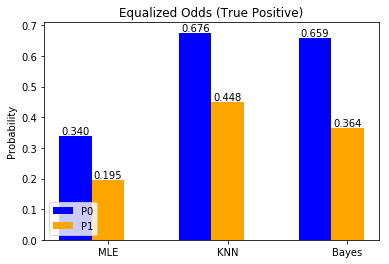

In [52]:
plot_fairness(EO_pos, "Equalized Odds (True Positive)")

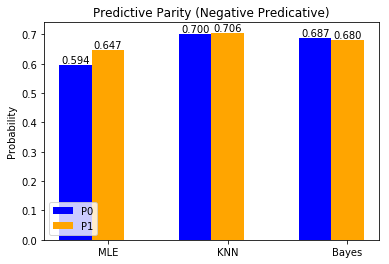

In [53]:
plot_fairness(PP_neg, "Predictive Parity (Negative Predicative)")

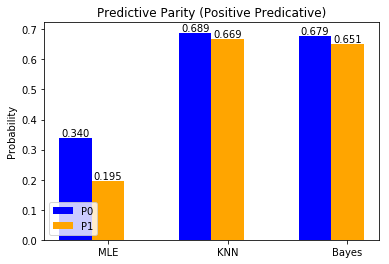

In [54]:
plot_fairness(PP_pos, "Predictive Parity (Positive Predicative)")